<a href="https://colab.research.google.com/github/stasysdr/dnn-test/blob/main/Artificial_neural_network_demo_Number_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is a demonstration of artificial neural networks - how the code looks like, how the models of deep neural networks are created, trained, and tested.

The purpose of this demonstration is to illustrate the following legal points:
* Artificial Neural Network coding can be simple and technical, where copyright protection of the code would not be most important
* where are "hyperparameters" of the ANN in the code and how they look like. They can be the hardest to figure out and therefore they qualify for legal protection as trade secrets
* how the weights look like in the trained ANN, as they may be protected as database

In this demonstration the deep neural network model will have two convolutional layers of artificial neurons, one dense layer of artificial neurons, and final layer for classification.

The model will be use for computer vision task - to recognise digits (from 0 to 9) in the images.

# Most of the code is already written

As you will see, there is little coding required for machine learning task.

This is because the code is already packed in so called "libraries", and you can use large portions of that just by asking to execute required functions, which have short names.

Most such libraries are open source and free to use.

tensorflow - is the core library developed by Google for internal use, but then released to the public. There are more such libraries, such as pytorch. In this demonstration we will use tensorflow.

keras - is a high-level library built on top of tensorflow. It makes easier to create models faster, as less coding is required. However, using tensorflow, would allow you to fine-tune your machine learning program, but require more code.

Let's see how these libraries are added (imported), when we write the code in python language.

Play the code below. You may receive warning regarding access. ***The code in this demo does not need and will not ask for access to your files.***

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, utils, Sequential

As you see, these are amazingly simple lines, but they will let to access prewritten code in your python programme later.

We use import "long name" as "short name", because later in code its easier to repeatedly refer to "tf", rather than "tensorflow".

We will only use parts of keras library - models, layers, utils, so we import only those parts, which makes accessing those parts in the code shorter.

We will also need some other libraries, which help display images, and plot graphs.

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt # This library will plot graphs to visualise data and images

import pathlib
import numpy as np # Library needed for calculations with image pixel values

# Getting the data for training the model

First, we have to get data - many examples of images containing digits from 1 to 10.

The data is publicly availabe at the address you see below. You can download it yourself to inspect what's inside.

Let's play the cell bellow to retrieve the data and unpack it into this Colab environment.

In [ ]:
dataset_url = "https://github.com/stasysdr/dnn-test/raw/main/digits.tgz" # you can copy paste this address and get the archived images used in this demo
data_dir = utils.get_file('digits.tar', origin=dataset_url, extract=True,cache_dir="/content")
data_dir = pathlib.Path(data_dir).with_suffix('')

Now let's count how many images are there in the obtained dataset. Should be 796.

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

# Inspecting the data

Now let's see what the images contain, and what our neural network will have to recognise.

Let's display one image for each class. As we will classify the images into 10 classes (from 0 to 9), we have to see 10 images.

In [ ]:
fig, axs = plt.subplots(ncols=10, nrows=1, figsize=(10,1),)
for i in range(10):
    dir = str(i)+"/*"
    digit = list(data_dir.glob(dir))
    im = Image.open(digit[i])
    axs[i].imshow(im)
    axs[i].axis("off")

Now let's take a closer look at one image of a digit "1".

In [ ]:
im = Image.open(list(data_dir.glob('1/tet1-4.png'))[0])
plt.axis("off")
plt.imshow(im)
plt.show()

We humans see the images visually, but if you expand the image enough, you start seeing pixels. This is an image of total 18 pixels vertically and 20 pixels horizontally.

Of course, computers do not, and our neural network model will not, "see" visually, but they understand numbers.

For a computer, each pixel is a number. See for yourself.


In [ ]:
ima = np.asarray(im.convert('RGB'))
ima = np.dot(ima[..., :3], [0.2989, 0.5870, 0.1140])
fig, ax = plt.subplots(figsize=(7.8,7.5))
ax.imshow(im)
for i in range(18):
    for j in range(20):
        ax.text(j,i,f"{int(ima[i][j])}", color=("k" if ima[i][j]>150 else "w"),fontsize=8, horizontalalignment="center", verticalalignment="center")
plt.axis("off")
plt.show()

The pixels are numbers from 0 to 255, representing colour. The neural network will make calculations with these numbers and "learn" to recognise the whole 'picture' they represent.

# Datasets for training and validation

Our Neural Network will train by inspecting and making calculations with the set of images, which are labelled by human, and will try to calculate which label (class) should be assigned to the image (classes are from 0 to 9).

Over more and more training cycles, the neural network model will get better and better at calculating the correct labels.

However, as a good practice, it is not sufficient to rely only on the results of calculations made on the data on which the model was trained, because the model has already "seen" those images on which it was trained.

Therefore, we will split all the images into 80% for training, and 20% for validation data sets.

Validation data will be used for training, but will be used after training to check how the model is doing with data it has not yet "seen", when training.

Strangely, the "training data" and "validation data" definitions found their way even in [EU Artificial Intelligence Act](https://eur-lex.europa.eu/eli/reg/2024/1689/oj), Article 3(29), 3(30), and training the models on both those datasets is a legal requirement for data governance under Article 10:

> 1.   High-risk AI systems which make use of techniques involving the training of AI models with data shall be developed on the basis of training, validation and testing data sets that meet the quality criteria referred to in paragraphs 2 to 5 whenever such data sets are used.

 [...]
> 3. Training, validation and testing data sets shall be relevant, sufficiently representative, and to the best extent possible, free of errors and complete in view of the intended purpose. They shall have the appropriate statistical properties, including, where applicable, as regards the persons or groups of persons in relation to whom the high-risk AI system is intended to be used. Those characteristics of the data sets may be met at the level of individual data sets or at the level of a combination thereof.





## Creating training and validation datasets

Let's create a training data set.

We will define the size of the images - each image used for training must have exactly the same number of pixels, so defining the size of images helps adjust the images in case they are different in size. In our case they are all the same 18 pixels height by 20 pixels width.

batch_size - will define the number of images used in one batch for training cycle.  It would required a lot of computer memory to take all hundreds of images at once. Therefore, we do one training cycle with a set of 32 images.

"Batch size" is one of the **hyperparameters**, which can be adjusted to improve training, as training may have a bit different results if we train with more or less images at a time.

As adjusting hyperparameters requires manual work, they are particularly important part of a model as they may become a "trade secret" from legal point of view. We will return to hyperparameters later.

In [ ]:
batch_size = 32 # defines how many images will be fed to the model at a time for one training cycle

img_height = 18
img_width = 20

We will convert our images from colour (RBG) to grayscale format, so there is less data in each image. RGB would have three numbers to define each pixel, and grayscale only one.

The images are saved as .png files in the following directory structure:
```
digits/
  0/
    tet101-3.png
    tet102-3.png
    ..
  1/
    tet1-4.png
    ..
  2/
    tet10-1.png
    tet101-2.png
    ..
  3/
    tet108-4.png
    ..
  4/
    tet10-2.png
    ..
  5/
    tet100-2.png
    ..
  6/
    tet1-1.png
    ..
  7/
    ..
  8/
    ..
  9/
    ..
```

So the directory names serve as labels - all images in a directory will be assigned the relevant label, e.g. "1", "7", etc. No need to fix a label for each individual image.

This is what the so called "labelled data" looks like.

In [ ]:
training_data_set, validation_data_set = utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

As you see, just one line of code referring to keras.utils library and using the function "image_dataset_from_directory" does all the job of selecting 80% of images for training, 20% of images for validation, organising them into batches of 32 images, and converting them to grayscale. This is really cool.

## Checking the data

Let's now check if the labels were taken into the datasets. They are read from the names of the directories for each class of numbers.

In [ ]:
class_names = training_data_set.class_names
print(class_names)

And let's also make sure that images in the training dataset have correct labels and are uniform. We will take 8 sample images and labels.

In [ ]:
fig = plt.figure(figsize=(7, 3.5))
for images, labels in training_data_set.take(1):
  for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(images[i].numpy().astype("uint8"),cmap="gray")
    ax.set_title(class_names[labels[i]])
    ax.axis("off")

# Deep artificial neural network

Here is where the magic will be happening.

We will use a simple model of only four layers of artificial neurons. Not so deep network.

First two layers are 'convolutional'. Do not worry about the meaning of this term. Just know that such type of layers allow us to have less artificial neurons than the number of pixels in the image, and they are very efficient in learning to analyse images.

In those layers the neurons will be arranged into 3 by 3 filters. Think of a filter like a matrix:

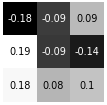

They will try to calculate the so called parameters, in order to find those, which predict the label of an image previously unseen by the neural network, as best and as accurate as possible.

Remember, that an artificial neuron is a place in the network, where very simple calculations are happening always under the same formula:

w1 * x1 + b

where

  w1 - trainable parameter (called 'weight')

  x1 - real world feature, in our case - number representing a singl pixel of a picture

  b -  bias, nothing related to 'bias' in legal sense, also a trainable parameter.

After the fist iteration, the result of the formula (predicted label of image) is checked against the actual label. If there is deviation, w1 will be modified a little, to try to find better parameter w1. This is how the network is trained, and how the machines learn - they try to find best parameters (weights).

Let's take a look at the code. As you see, with keras it takes one line of code to define a layer with 160 or one line for a layer with 4640 trainable parameters.

Let's activate the code and build the model.

In [ ]:
filter_size = 3 # this determines the size of a filter in the below code - 3 * 3 = 9 trainable weights

model = Sequential([
  #layers.Input(shape=(img_height, img_width, 1)),
  layers.Rescaling(1./255, name='rescaling'),
  layers.Conv2D(16, filter_size, activation='relu', name='first'),  # 16 filters of size 3*3 (144 weights)  + bias for each filter (16) = 160 total weights
  layers.Conv2D(32, filter_size, activation='relu', name='antras'), # 32 filters of size 3*3 times 16 filters from previous layer + bias = 4640
  layers.Flatten(name='flat'), # this layer puts all weights in one line, i.e. "flattens" the matrixes of filters from previous layers
  layers.Dense(64, activation='relu', name='dense'), # this is a "dense" layer with 64 artificial neurons. They calculate ('train') total 458,752 weights and 64 biases
  layers.Dense(len(class_names), name='classify') # final layer for classification into 10 classes, it has ten neurons, one for each class.
], name='digitrecognition')

# nummber of layers, number of filters, size of filters, activation function, are all hyperparameters

The model is defined and stored in a variable "model".

Now let's compile and build the model. Then we will see the summary of information about the model, the total number of trainable parameters.

In [ ]:
model.compile(optimizer='adam', # adam - this is a type of optimization, which is a hyperparameter
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.build((None,img_height, img_width, 1))
model.summary()

This is it, the model is created and built, we can now train it, but first, let's talk about "hyperparameters" - the very secret of the neural network.

## Hyperparameters as trade secrets

When building an artificial neural network, we usually do not know in advance, which structure is best.

* How many layers should the network have?

* How many artificial neurons there should be in a layer?

* If we use convolutional layer, how many filters? What size? 3x3 or 5x5? Should we use padding? What stride is best? Should we add max (or average) pooling layer?

* Which activation function should be use? (in our model, we use 'relu', but is it best)?

The more layers, the more neurons or filters, the more computing resources and time training will require.

All these questions can be answered only by trying the network.

Of course, there is experience publicly available which can provide some suggestions. But for more customised or complex applications, those questions can be answered only by building and trying the artificial networks.

This is why it requires investment of time, effort, consumption of computing resources.

And once those hyperparameters are found and we have a model which works best, this is the knowledge, which is developed by effort and therefore can qualify as a trade secret from legal point of view.

# Training the artificial neural network

We will now train the model, by fitting the training data set of images, 637 in total.

It is not feasible to stuff all images at once, so we will feed them in batches of 32 images - total 20 batches. After each batch, the weights are updated to see how the other batch will perform. After all batches (i.e. all images) are through the training process, we complete one training cycle. The cycle is called "Epoch".

During one training cycle, the trainable parameters are tested by calculating predictions of labels of images. If prerdicted labels are off, the parameters are adjusted to try to improve the model accuracy.

In [ ]:
initial_weights = model.get_layer(name="first").get_weights() # this will keep the original weights, which are initiated to random values

accr, loss, val_acc = [], [], []
class training_logs(tf.keras.callbacks.Callback): # to keep record of training cycles, needed to print accuracy graphs later

  def on_epoch_begin(self, epoch, logs=None):
    self.ep = epoch

  def on_batch_end(self, batch, logs=None):
    accr.append(logs['accuracy'])
    loss.append(logs['loss'])

  def on_epoch_end(self, epoch, logs=None):
    val_acc.append(logs['val_accuracy'])


Let's run 5 epochs, or training cycles.

In [ ]:
epochs=5  #the number of epochs or training cycles
history = model.fit( # this will initiate the training of the model on the tain_ds data set
  training_data_set,
  validation_data=validation_data_set,
  epochs=epochs,
  callbacks=[training_logs()],
  verbose=1
)

## Visualising the 'training' of the weights

Now let's look at the weight as they were initialised into random numbers and how they changed during learning process.

The code below will display values of all 160 weights of the first layer of artificial neurons before and after the training.

In [ ]:
learned_weights = model.get_layer(name="first").get_weights()
compare_weights = {"0": initial_weights,
                   "1": learned_weights}

fig = plt.figure(figsize=(11,6), constrained_layout=True)
subfigs = fig.subfigures(1, 2, wspace=0.05)

for outerind, subfig in enumerate(subfigs.flat):
  axs = subfig.subplots(4, 4)

  subfig.suptitle('Initial random weights' if outerind == 0 else 'Weights learned by neurons in the first layer of network', y=1.05);
  for innerind, ax in enumerate(axs.flat):
    ax.imshow(compare_weights[str(outerind)][0][:,:,0,innerind],cmap="gray")
    ax.axis("off")
    ax.set_title(str(int(compare_weights[str(outerind)][1][innerind]*1000)/1000), y=0, pad=-3, verticalalignment="top",fontsize=7)
    for a in range(3):
      for b in range(3):
        ax.text(a, b, int(compare_weights[str(outerind)][0][b,a,0,innerind]*100)/100,
                color=("k" if compare_weights[str(outerind)][0][b,a,0,innerind]>0 else "w"),
                fontsize=7, horizontalalignment="center", verticalalignment="center");

Now let's visualise by how much the weights got trained in 3d :)

There are 16 filters, having 9 weights each (3x3).

In [ ]:
x,y,z = [],[],[]

for i in range(4): # Arranging x and y positions for each neuron
  a=1
  for k in range(12):
    for j in range(1,4):
      x.append([j+i*3,j+i*3])
      y.append([a,a])
    a = a+1

for i in range(16): # Getting z length (height) for eac neuron
  for k in range(3):
    for l in range(3):
      z.append( [1, 1+abs(initial_weights[0][k,l,0,i]-learned_weights[0][k,l,0,i])])

# Ploting all neurons in 3d projection
fig = plt.figure( figsize = (8, 8))
clr = plt.colormaps['hsv'](np.random.rand(16,))
i=0
fig.suptitle(f"The extent of change of weights during learning", ha='center')
for s in range(16): # iterating through 16 filters
  ax = fig.add_subplot(4,4,s+1,projection='3d')
  for t in range(9): # Iterating through 9 weights of each filter
    ax.plot(x[i], y[i], z[i], 'o', linestyle=(0,(1,0)), linewidth=2.0, c=clr[s])
    i=i+1
  ax.axis("off")
  ax.set_title(f"{s+1} filter", fontsize=9, y=0.95)
plt.show()

The height of 3d bars shows the difference between initial value and the value after training.

As you see, the weights are adjusted by learning process. This is how machines "learn" and how they "remember" what they learned - they keep the weights in their "memory".

## Weights as databases

As it takes effort to create the ‘database’ of weights, the collection of this particular data qualifies as a protected database from legal point of view. Database is defined as a collection of data arranged in a systematic or methodical way and individually accessible by electronic or other means.

Databases are legally protected, if there has been qualitatively and/or quantitatively a substantial investment in either the obtaining, verification or presentation of the contents of the database.

As it takes intellectual effort to find the correct values of weights, and also it can require significant cost in terms of computing power and time, the system of weights learned by a neural network may be legally protected as a database.

Below code will display a small fraction of the database of the trained weights - the weights of one filter of first layer of the network, i.e. 10 weights out of total 464,266.

In [ ]:
# Print the weights of first filter of first layer in pure numbers
np.set_printoptions(suppress=True)
print(f"Initial weights:\n{initial_weights[0][:,:,0,0]}\nbias:{initial_weights[1][0]}\n")
print(f"Learned weights:\n{learned_weights[0][:,:,0,0]}\nbias:{learned_weights[1][0]}\n")
print(f"Difference (absolute):\n{abs(learned_weights[0][:,:,0,0]-initial_weights[0][:,:,0,0])}\nbias:{abs(learned_weights[1][0]-initial_weights[1][0])}")

# Testing the trained network

We will now load 20 images, which were not included in training or validation datasets, i.e. they are completely 'unseen' by the neural network.

The network will calculate the labels using the weights it learned so far. We can call such calculated labels as 'predictions', because the network does not 'know' if the calculated label is actually correct.

However, the network can calculate how confident the prediction is, i.e. by how much the calculated label is likely to be correct, in comparison with other labels.

In [ ]:
imlist = list(pathlib.Path('/content/datasets/digitstest/').glob('*/*.png'))

def load_and_preprocess_image(image_path):
  # Load image
  img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width), color_mode='grayscale')
  img = tf.keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)  # Add batch dimension
  return img

def print_model_predictions():

  images = [load_and_preprocess_image(path) for path in imlist]
  images = np.vstack(images)  # Combine images into a batch

  predictions = model.predict(images, verbose=0) # Run the images through the trained model
  predicted_labels = np.argmax(predictions, axis=1) # Calculated predicted labels
  true_labels = [int(str(i)[29]) for i in imlist] # Read true labels from image folders
  accuracy = np.sum(predicted_labels == true_labels)/len(true_labels) # Calculate accuracy

  # Print results
  fig = plt.figure(figsize=(7, 6))
  fig.suptitle(f"Predicted labels and confidence level (%) of predictions\n", ha='center')
  plt.title(f"Accuracy of the trained model - {int(accuracy*1000)/10}%", fontsize=11, y=1.03)
  plt.axis("off")

  for f in range(len(imlist)): # Loop through each evaluated image

      score = tf.nn.softmax(predictions[f])
      confidence = "" + str(int(1000 * np.max(score))/10)+"%"

      label = ""+str(predicted_labels[f])
      correct_label = true_labels[f] == predicted_labels[f]

      ax = fig.add_subplot(4, int(len(imlist)/4), f + 1)
      ax.imshow(Image.open(imlist[f]))
      ax.set_title(label+"", loc="center", fontsize=12)
      ax.set_title(confidence, loc="right", fontsize=8)
      ax.set_title("correct" if correct_label else "false" , loc="left", fontsize=7, c="g" if correct_label else "r")
      ax.set_xticks([])
      ax.set_yticks([])

print_model_predictions()

You see that after training for 5 epochs, our model has an average performance - it correctly predicts labels of images only in 1 out of 2, which is quite low performance.

Let's run a few more epochs to train the model better.

In [ ]:
history = model.fit(
  training_data_set,
  validation_data=validation_data_set,
  epochs=5,
  verbose=1,
  callbacks=[training_logs()]
)

Let's see if the accuracy improved.

In [ ]:
print_model_predictions()

You can repeat the steps above to see if the model improves further.

At some point the model may even reach 100% accuracy.

The below code will display a graph of how accuracy and validation accuacy inceased during training.

In [ ]:
plt.plot(range(1,len(accr)+1),accr),

plt.plot(range(20,len(accr)+1,20), val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xticks(range(0, len(accr),20), range(1,len(val_acc)+1))
plt.xlabel('Epoch')
plt.legend(['Accuracy at end of batch', 'Validation accuracy at end of epoch'], loc='lower right')
plt.show()

# How the trained network 'sees'
Below is a visualisation of what one of the model layers learns. This is how filters recognise patterns in the images.

In [ ]:
layer_name = 'first'
imgh = img_height
imgw = img_width
layer = model.get_layer(name=layer_name)
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def initialize_image():
    for images, labels in training_data_set:
        img = images[0] #.numpy().astype("float")
        break
    img = np.expand_dims(img, axis=0)
    img.shape
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, imgh, imgw, 1))
    return img


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 50
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[0:25, 0:25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

for i in range(16):
  loss, img = visualize_filter(i)
  plt.subplot(4,4,i+1)
  plt.imshow(img, cmap='gray')
  plt.axis("off")

# Full code of artificial neural network

Here is the minimal full code for extracting data, creating datasets, defining the artificial neural network model and training the model.

As you see, these are onl a few lines of standard code, therefore they would not pass the originality threshold to qualify for copyright protection.

Of course, complex models with customised code may become copyright protected, but they should not be just standard call to available functions.

```
import tensorflow as tf
from tensorflow.keras import layers, models, utils
import pathlib

dataset_url = "https://github.com/stasysdr/dnn-test/raw/main/digits.tgz"
data_dir = utils.get_file('digits.tar', origin=dataset_url, extract=True,cache_dir="/content")
data_dir = pathlib.Path(data_dir).with_suffix('')

batch_size = 32
img_height, img_width = 18, 20

training_data_set, validation_data_set = utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

model = tf.keras.models.Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(10)
])

model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(
  training_data_set,
  validation_data=validation_data_set,
  epochs=5
)

```



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils, Sequential
import pathlib

dataset_url = "https://github.com/stasysdr/dnn-test/raw/main/digits.tgz"
data_dir = utils.get_file('digits.tar', origin=dataset_url, extract=True,
                          cache_dir="/content")
data_dir = pathlib.Path(data_dir).with_suffix('')

batch_size = 32
img_height, img_width = 18, 20

training_data_set, validation_data_set = utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(10)
])

model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(
  training_data_set,
  validation_data=validation_data_set,
  epochs=15
)